In [6]:

import torch
import argparse
from pathlib import Path
import numpy as np
from src.model_utils import build_model
import src.datasets as datasets
import src.evaluation as evaluation
from src.torch_utils import torch2numpy
from reevaluate import get_test_dataset
from tqdm import tqdm

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [275]:
def get_quantile_forecast(pred, quantile, axis=0):
    # shape is [num_samples, num_series, prediction_length]
    # return the quantile of the samples for each series
    return np.quantile(pred, quantile, axis=axis)


In [2]:
ckpt_file = "./Checkpoints/bouncing_ball.pt"
ckpt = torch.load(ckpt_file, map_location="cpu")

config = ckpt["config"]
model = build_model(config=config)
model.load_state_dict(ckpt["model"])

test_dataset = get_test_dataset(config)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=80)
extra_args = dict()
extra_args = {"dur_temperature": 1.0}
device = 'cpu'

In [3]:
def autoregressive_pred(ckpt_file, batch_size=80):

    ckpt = torch.load(ckpt_file, map_location="cpu")

    config = ckpt["config"]
    model = build_model(config=config)
    model.load_state_dict(ckpt["model"])

    test_dataset = get_test_dataset(config)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

    #do predictions autoregressively. 
    context_length = config['context_length']
    prediction_length = config['prediction_length']
    ground_truth = []
    all_lb = []
    all_ub = []
    all_mean = []
    # calculate coverage and width of prediction intervals
    for test_batch, test_label in test_loader:
        true = test_batch[:, -prediction_length:]
        autoregressive_lb = []
        autoregressive_ub = []
        autoregressive_mean = []
        for t in tqdm(range(prediction_length)):
            pred = model.predict(test_batch[:,t:t+context_length], num_samples=100, pred_one_step=True)
            pred_y = pred['rec_n_forecast'][:,:,-1]

            mean = get_quantile_forecast(pred_y, 0.5)
            lb = get_quantile_forecast(pred_y, 0.1)
            ub = get_quantile_forecast(pred_y, 0.9) 

            autoregressive_lb.append(lb)
            autoregressive_ub.append(ub)
            autoregressive_mean.append(mean)

        ground_truth.append(true)
        all_lb.append(np.concatenate(autoregressive_lb, 1))
        all_ub.append(np.concatenate(autoregressive_ub, 1))
        all_mean.append(np.concatenate(autoregressive_mean, 1))
    
    ground_truth = np.concatenate(ground_truth, 0).squeeze()
    all_lb = np.concatenate(all_lb, 0)
    all_ub = np.concatenate(all_ub, 0)
    all_mean = np.concatenate(all_mean, 0)

    return ground_truth, all_mean, all_lb, all_ub

def autoregressive_get_truth(ckpt_file):
    ckpt = torch.load(ckpt_file, map_location="cpu")

    config = ckpt["config"]
    model = build_model(config=config)
    model.load_state_dict(ckpt["model"])
    prediction_length = config['prediction_length']

    test_dataset = get_test_dataset(config)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=80)
    all_truth = []
    for test_batch, test_label in test_loader:
        true = test_batch[:, -prediction_length:]
        all_truth.append(true)
    all_truth = np.concatenate(all_truth, 0)
    return all_truth

In [22]:
ckpt_bb = "./Checkpoints/bouncing_ball.pt"
ckpt_bbnoisy = "./Checkpoints/bb_noisy.pt"

In [23]:
ground_truth, all_mean, all_lb, all_ub = autoregressive_pred(ckpt_bb)


  0%|          | 0/50 [00:00<?, ?it/s]/Users/sophiasun/Desktop/2cool4school/phd/switching/REDSDS/src/torch_utils.py:37: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  indices = indices // dim
100%|██████████| 50/50 [01:09<00:00,  1.40s/it]


In [29]:

ground_truth = np.concatenate(ground_truth, 0)
all_lb = np.concatenate(all_lb, 0)
all_ub = np.concatenate(all_ub, 0)
all_mean = np.concatenate(all_mean, 0)


In [48]:
ground_truth = autoregressive_get_truth(ckpt_bb).squeeze()

In [49]:
ground_truth.shape

(1000, 50)

In [47]:
all_lb.shape

(1000, 50)

In [52]:

# coverage
coverage = np.mean(np.logical_and(ground_truth >= all_lb, ground_truth <= all_ub))
# width
width = np.mean(all_ub - all_lb)


coverage, width

(0.78572, 0.5273508853956397)

In [53]:
np.savez("./results/bouncing_ball_autoregressive.npz", ground_truth=ground_truth, mean=all_mean, lb=all_lb, ub=all_ub)


## Noisy

In [57]:
ground_truth, all_mean, all_lb, all_ub = autoregressive_pred(ckpt_bbnoisy)

#save ground truth, all_mean, all_lb, all_ub
np.savez("./results/bouncing_ball_noisy_autoregressive.npz", ground_truth=ground_truth, mean=all_mean, lb=all_lb, ub=all_ub)


  0%|          | 0/50 [00:00<?, ?it/s]

/Users/sophiasun/Desktop/2cool4school/phd/switching/REDSDS/src/torch_utils.py:37: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  indices = indices // dim
100%|██████████| 50/50 [01:06<00:00,  1.33s/it]


In [58]:

# coverage
coverage = np.mean(np.logical_and(ground_truth >= all_lb, ground_truth <= all_ub))
# width
width = np.mean(all_ub - all_lb)


coverage, width

(0.78504, 0.46371949870007767)

# Electricity

In [122]:
dataset = datasets.GTSUnivariateDataset("electricity_nips", batch_size=50, mode="test")
test_dataset = dataset.gluonts_dataset

In [276]:
ckpt_file = "Checkpoints/electricity_nips.pt"
try:
    ckpt = torch.load(ckpt_file, map_location="cpu")
except FileNotFoundError:
    print(f"Can't find {ckpt_file}!")

config = ckpt["config"]
device = 'cpu'
model = build_model(config=config)
model.load_state_dict(ckpt["model"])
model = model.to(device)

In [277]:
from src.datasets import create_input_transform
from gluonts.dataset.loader import InferenceDataLoader
from gluonts.torch.batchify import batchify
import pandas as pd

from gluonts.transform import TransformedDataset
from gluonts.transform import AdhocTransform


batch_size = 10
assert dataset.metadata["context_length"] == model.context_length
assert dataset.metadata["prediction_length"] == model.prediction_length
prediction_length = dataset.metadata["prediction_length"]
context_length = dataset.metadata["context_length"]

freq = dataset.freq
max_len = 1000

def add_ts_dataframe(data_iterator):
    for data_entry in data_iterator:
        data = data_entry.copy()
        index = pd.date_range(
            start=data["start"],
            freq=freq,
            periods=data["target"].shape[-1],
        )
        data["ts"] = pd.DataFrame(index=index, data=data["target"].transpose())
        yield data

def test_generator(dataset):
    size = 0
    for data_entry in add_ts_dataframe(iter(dataset)):
        if size < max_len:
            yield data_entry["ts"]
            size += 1
        else:
            break

def truncate_target(data):
    data = data.copy()
    target = data["target"]
    assert (
        target.shape[-1] >= prediction_length
    )  # handles multivariate case (target_dim, history_length)
    data["target"] = target[..., :-prediction_length]
    return data

trucated_dataset = TransformedDataset(
    test_dataset, transformation=AdhocTransform(truncate_target)
)

input_transform = create_input_transform(
    is_train=False,
    prediction_length=prediction_length,
    past_length=context_length,
    use_feat_static_cat=True,
    use_feat_dynamic_real=False,
    freq=freq,
    time_features=None,
)
inference_loader = InferenceDataLoader(
    dataset=trucated_dataset,
    transform=input_transform,
    batch_size=batch_size,
    stack_fn=batchify,
    #num_workers=1,
)

In [367]:
from gluonts.model.forecast import SampleForecast

def prediction_generator(inference_loader, num_samples=100, max_len = 100):
    size = 0
    for batch in inference_loader:
        ys = batch["past_target"]
        forecast_starts = batch["forecast_start"]
        item_ids = (
            batch["item_id"]
            if "item_id" in batch
            else [int(x[0]) for x in batch["feat_static_cat"]]
        )
        assert ys.shape[-2] == context_length

        rec_n_forecast = (
            model.predict(
                ys.to(device),
                ctrl_inputs=dict(
                    feat_static_cat=batch["feat_static_cat"].long().to(device),
                    past_time_feat=batch["past_time_feat"].to(device),
                    future_time_feat=batch["future_time_feat"].to(device),
                ),
                num_samples=num_samples,
            )["rec_n_forecast"]
            .data.cpu()
            .numpy()
        )
        assert rec_n_forecast.shape[-2] == prediction_length + context_length, (
            f"Length of rec + forecast {rec_n_forecast.shape[-2]}"
            f" along time dimension should be "
            f"context_length {context_length} "
            f"+ prediction_length {prediction_length}"
        )
        # get rid of the truncation
        forecasts = rec_n_forecast[..., -prediction_length:, :]
        all_preds = rec_n_forecast

        forecasts = np.swapaxes(forecasts, 0, 1)
        all_preds = np.swapaxes(all_preds, 0, 1)

        if forecasts.shape[-1] == 1:
            all_preds = all_preds.squeeze(-1)
            forecasts = forecasts.squeeze(-1)

        for forecast_start, item_id, forecast, everything in zip(
            forecast_starts, item_ids, forecasts, all_preds
        ):
            if size < max_len:
                sf = SampleForecast(
                    samples = forecast,
                    start_date=forecast_start,
                    freq=freq,
                    item_id=item_id,
                )
                yield sf, everything
                size += 1
            else:
                break
        if size == max_len:
            break



In [366]:
max_len = 20

pred_gen = prediction_generator(inference_loader, max_len=max_len)
test_gen = test_generator(test_dataset)

ts_iterator = iter(test_gen)
fcst_iterator = iter(pred_gen)
ground_truth, all_mean, all_lb, all_ub = [], [], [], []
prev_preds = []
size = 0

with tqdm(
    zip(ts_iterator, fcst_iterator),
    total=max_len,
    desc="Running evaluation",
) as it, np.errstate(invalid="ignore"): 
    
    for ts, (forecast, everything) in it:
        #print(forecast.samples.shape)
        rec_n_forecast = forecast.samples[..., -prediction_length:]
        print(len(forecast.index))
        print(type(forecast.index))
        target = np.atleast_1d(
            np.squeeze(ts.loc[forecast.index].transpose())
        )

        mean = get_quantile_forecast(rec_n_forecast, 0.5)#axis=1)
        lb = get_quantile_forecast(rec_n_forecast, 0.1)#axis=1)
        ub = get_quantile_forecast(rec_n_forecast, 0.9)#axis=1) 
        prev_mean = get_quantile_forecast(forecast.samples[..., :-prediction_length], 0.5)#, axis=1) 


        all_lb.append(lb)
        all_ub.append(ub)
        all_mean.append(mean)
        ground_truth.append(target)
        prev_preds.append(prev_mean)



Running evaluation:   0%|          | 0/20 [00:00<?, ?it/s]/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/Users/sophiasun/Desktop/2cool4school/phd/switching/REDSDS/src/torch_utils.py:37: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  indices = indices // dim
Running evaluation:   0%|          | 0/20 [00:02<?, ?it/s]

504
<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


KeyError: "[Timestamp('2014-09-02 01:00:00'), Timestamp('2014-09-02 02:00:00'), Timestamp('2014-09-02 03:00:00'), Timestamp('2014-09-02 04:00:00'), Timestamp('2014-09-02 05:00:00'), Timestamp('2014-09-02 06:00:00'), Timestamp('2014-09-02 07:00:00'), Timestamp('2014-09-02 08:00:00'), Timestamp('2014-09-02 09:00:00'), Timestamp('2014-09-02 10:00:00'), Timestamp('2014-09-02 11:00:00'), Timestamp('2014-09-02 12:00:00'), Timestamp('2014-09-02 13:00:00'), Timestamp('2014-09-02 14:00:00'), Timestamp('2014-09-02 15:00:00'), Timestamp('2014-09-02 16:00:00'), Timestamp('2014-09-02 17:00:00'), Timestamp('2014-09-02 18:00:00'), Timestamp('2014-09-02 19:00:00'), Timestamp('2014-09-02 20:00:00'), Timestamp('2014-09-02 21:00:00'), Timestamp('2014-09-02 22:00:00'), Timestamp('2014-09-02 23:00:00'), Timestamp('2014-09-03 00:00:00'), Timestamp('2014-09-03 01:00:00'), Timestamp('2014-09-03 02:00:00'), Timestamp('2014-09-03 03:00:00'), Timestamp('2014-09-03 04:00:00'), Timestamp('2014-09-03 05:00:00'), Timestamp('2014-09-03 06:00:00'), Timestamp('2014-09-03 07:00:00'), Timestamp('2014-09-03 08:00:00'), Timestamp('2014-09-03 09:00:00'), Timestamp('2014-09-03 10:00:00'), Timestamp('2014-09-03 11:00:00'), Timestamp('2014-09-03 12:00:00'), Timestamp('2014-09-03 13:00:00'), Timestamp('2014-09-03 14:00:00'), Timestamp('2014-09-03 15:00:00'), Timestamp('2014-09-03 16:00:00'), Timestamp('2014-09-03 17:00:00'), Timestamp('2014-09-03 18:00:00'), Timestamp('2014-09-03 19:00:00'), Timestamp('2014-09-03 20:00:00'), Timestamp('2014-09-03 21:00:00'), Timestamp('2014-09-03 22:00:00'), Timestamp('2014-09-03 23:00:00'), Timestamp('2014-09-04 00:00:00'), Timestamp('2014-09-04 01:00:00'), Timestamp('2014-09-04 02:00:00'), Timestamp('2014-09-04 03:00:00'), Timestamp('2014-09-04 04:00:00'), Timestamp('2014-09-04 05:00:00'), Timestamp('2014-09-04 06:00:00'), Timestamp('2014-09-04 07:00:00'), Timestamp('2014-09-04 08:00:00'), Timestamp('2014-09-04 09:00:00'), Timestamp('2014-09-04 10:00:00'), Timestamp('2014-09-04 11:00:00'), Timestamp('2014-09-04 12:00:00'), Timestamp('2014-09-04 13:00:00'), Timestamp('2014-09-04 14:00:00'), Timestamp('2014-09-04 15:00:00'), Timestamp('2014-09-04 16:00:00'), Timestamp('2014-09-04 17:00:00'), Timestamp('2014-09-04 18:00:00'), Timestamp('2014-09-04 19:00:00'), Timestamp('2014-09-04 20:00:00'), Timestamp('2014-09-04 21:00:00'), Timestamp('2014-09-04 22:00:00'), Timestamp('2014-09-04 23:00:00'), Timestamp('2014-09-05 00:00:00'), Timestamp('2014-09-05 01:00:00'), Timestamp('2014-09-05 02:00:00'), Timestamp('2014-09-05 03:00:00'), Timestamp('2014-09-05 04:00:00'), Timestamp('2014-09-05 05:00:00'), Timestamp('2014-09-05 06:00:00'), Timestamp('2014-09-05 07:00:00'), Timestamp('2014-09-05 08:00:00'), Timestamp('2014-09-05 09:00:00'), Timestamp('2014-09-05 10:00:00'), Timestamp('2014-09-05 11:00:00'), Timestamp('2014-09-05 12:00:00'), Timestamp('2014-09-05 13:00:00'), Timestamp('2014-09-05 14:00:00'), Timestamp('2014-09-05 15:00:00'), Timestamp('2014-09-05 16:00:00'), Timestamp('2014-09-05 17:00:00'), Timestamp('2014-09-05 18:00:00'), Timestamp('2014-09-05 19:00:00'), Timestamp('2014-09-05 20:00:00'), Timestamp('2014-09-05 21:00:00'), Timestamp('2014-09-05 22:00:00'), Timestamp('2014-09-05 23:00:00'), Timestamp('2014-09-06 00:00:00'), Timestamp('2014-09-06 01:00:00'), Timestamp('2014-09-06 02:00:00'), Timestamp('2014-09-06 03:00:00'), Timestamp('2014-09-06 04:00:00'), Timestamp('2014-09-06 05:00:00'), Timestamp('2014-09-06 06:00:00'), Timestamp('2014-09-06 07:00:00'), Timestamp('2014-09-06 08:00:00'), Timestamp('2014-09-06 09:00:00'), Timestamp('2014-09-06 10:00:00'), Timestamp('2014-09-06 11:00:00'), Timestamp('2014-09-06 12:00:00'), Timestamp('2014-09-06 13:00:00'), Timestamp('2014-09-06 14:00:00'), Timestamp('2014-09-06 15:00:00'), Timestamp('2014-09-06 16:00:00'), Timestamp('2014-09-06 17:00:00'), Timestamp('2014-09-06 18:00:00'), Timestamp('2014-09-06 19:00:00'), Timestamp('2014-09-06 20:00:00'), Timestamp('2014-09-06 21:00:00'), Timestamp('2014-09-06 22:00:00'), Timestamp('2014-09-06 23:00:00'), Timestamp('2014-09-07 00:00:00'), Timestamp('2014-09-07 01:00:00'), Timestamp('2014-09-07 02:00:00'), Timestamp('2014-09-07 03:00:00'), Timestamp('2014-09-07 04:00:00'), Timestamp('2014-09-07 05:00:00'), Timestamp('2014-09-07 06:00:00'), Timestamp('2014-09-07 07:00:00'), Timestamp('2014-09-07 08:00:00'), Timestamp('2014-09-07 09:00:00'), Timestamp('2014-09-07 10:00:00'), Timestamp('2014-09-07 11:00:00'), Timestamp('2014-09-07 12:00:00'), Timestamp('2014-09-07 13:00:00'), Timestamp('2014-09-07 14:00:00'), Timestamp('2014-09-07 15:00:00'), Timestamp('2014-09-07 16:00:00'), Timestamp('2014-09-07 17:00:00'), Timestamp('2014-09-07 18:00:00'), Timestamp('2014-09-07 19:00:00'), Timestamp('2014-09-07 20:00:00'), Timestamp('2014-09-07 21:00:00'), Timestamp('2014-09-07 22:00:00'), Timestamp('2014-09-07 23:00:00'), Timestamp('2014-09-08 00:00:00'), Timestamp('2014-09-08 01:00:00'), Timestamp('2014-09-08 02:00:00'), Timestamp('2014-09-08 03:00:00'), Timestamp('2014-09-08 04:00:00'), Timestamp('2014-09-08 05:00:00'), Timestamp('2014-09-08 06:00:00'), Timestamp('2014-09-08 07:00:00'), Timestamp('2014-09-08 08:00:00'), Timestamp('2014-09-08 09:00:00'), Timestamp('2014-09-08 10:00:00'), Timestamp('2014-09-08 11:00:00'), Timestamp('2014-09-08 12:00:00'), Timestamp('2014-09-08 13:00:00'), Timestamp('2014-09-08 14:00:00'), Timestamp('2014-09-08 15:00:00'), Timestamp('2014-09-08 16:00:00'), Timestamp('2014-09-08 17:00:00'), Timestamp('2014-09-08 18:00:00'), Timestamp('2014-09-08 19:00:00'), Timestamp('2014-09-08 20:00:00'), Timestamp('2014-09-08 21:00:00'), Timestamp('2014-09-08 22:00:00'), Timestamp('2014-09-08 23:00:00'), Timestamp('2014-09-09 00:00:00'), Timestamp('2014-09-09 01:00:00'), Timestamp('2014-09-09 02:00:00'), Timestamp('2014-09-09 03:00:00'), Timestamp('2014-09-09 04:00:00'), Timestamp('2014-09-09 05:00:00'), Timestamp('2014-09-09 06:00:00'), Timestamp('2014-09-09 07:00:00'), Timestamp('2014-09-09 08:00:00'), Timestamp('2014-09-09 09:00:00'), Timestamp('2014-09-09 10:00:00'), Timestamp('2014-09-09 11:00:00'), Timestamp('2014-09-09 12:00:00'), Timestamp('2014-09-09 13:00:00'), Timestamp('2014-09-09 14:00:00'), Timestamp('2014-09-09 15:00:00'), Timestamp('2014-09-09 16:00:00'), Timestamp('2014-09-09 17:00:00'), Timestamp('2014-09-09 18:00:00'), Timestamp('2014-09-09 19:00:00'), Timestamp('2014-09-09 20:00:00'), Timestamp('2014-09-09 21:00:00'), Timestamp('2014-09-09 22:00:00'), Timestamp('2014-09-09 23:00:00'), Timestamp('2014-09-10 00:00:00'), Timestamp('2014-09-10 01:00:00'), Timestamp('2014-09-10 02:00:00'), Timestamp('2014-09-10 03:00:00'), Timestamp('2014-09-10 04:00:00'), Timestamp('2014-09-10 05:00:00'), Timestamp('2014-09-10 06:00:00'), Timestamp('2014-09-10 07:00:00'), Timestamp('2014-09-10 08:00:00'), Timestamp('2014-09-10 09:00:00'), Timestamp('2014-09-10 10:00:00'), Timestamp('2014-09-10 11:00:00'), Timestamp('2014-09-10 12:00:00'), Timestamp('2014-09-10 13:00:00'), Timestamp('2014-09-10 14:00:00'), Timestamp('2014-09-10 15:00:00'), Timestamp('2014-09-10 16:00:00'), Timestamp('2014-09-10 17:00:00'), Timestamp('2014-09-10 18:00:00'), Timestamp('2014-09-10 19:00:00'), Timestamp('2014-09-10 20:00:00'), Timestamp('2014-09-10 21:00:00'), Timestamp('2014-09-10 22:00:00'), Timestamp('2014-09-10 23:00:00'), Timestamp('2014-09-11 00:00:00'), Timestamp('2014-09-11 01:00:00'), Timestamp('2014-09-11 02:00:00'), Timestamp('2014-09-11 03:00:00'), Timestamp('2014-09-11 04:00:00'), Timestamp('2014-09-11 05:00:00'), Timestamp('2014-09-11 06:00:00'), Timestamp('2014-09-11 07:00:00'), Timestamp('2014-09-11 08:00:00'), Timestamp('2014-09-11 09:00:00'), Timestamp('2014-09-11 10:00:00'), Timestamp('2014-09-11 11:00:00'), Timestamp('2014-09-11 12:00:00'), Timestamp('2014-09-11 13:00:00'), Timestamp('2014-09-11 14:00:00'), Timestamp('2014-09-11 15:00:00'), Timestamp('2014-09-11 16:00:00'), Timestamp('2014-09-11 17:00:00'), Timestamp('2014-09-11 18:00:00'), Timestamp('2014-09-11 19:00:00'), Timestamp('2014-09-11 20:00:00'), Timestamp('2014-09-11 21:00:00'), Timestamp('2014-09-11 22:00:00'), Timestamp('2014-09-11 23:00:00'), Timestamp('2014-09-12 00:00:00'), Timestamp('2014-09-12 01:00:00'), Timestamp('2014-09-12 02:00:00'), Timestamp('2014-09-12 03:00:00'), Timestamp('2014-09-12 04:00:00'), Timestamp('2014-09-12 05:00:00'), Timestamp('2014-09-12 06:00:00'), Timestamp('2014-09-12 07:00:00'), Timestamp('2014-09-12 08:00:00'), Timestamp('2014-09-12 09:00:00'), Timestamp('2014-09-12 10:00:00'), Timestamp('2014-09-12 11:00:00'), Timestamp('2014-09-12 12:00:00'), Timestamp('2014-09-12 13:00:00'), Timestamp('2014-09-12 14:00:00'), Timestamp('2014-09-12 15:00:00'), Timestamp('2014-09-12 16:00:00'), Timestamp('2014-09-12 17:00:00'), Timestamp('2014-09-12 18:00:00'), Timestamp('2014-09-12 19:00:00'), Timestamp('2014-09-12 20:00:00'), Timestamp('2014-09-12 21:00:00'), Timestamp('2014-09-12 22:00:00'), Timestamp('2014-09-12 23:00:00'), Timestamp('2014-09-13 00:00:00'), Timestamp('2014-09-13 01:00:00'), Timestamp('2014-09-13 02:00:00'), Timestamp('2014-09-13 03:00:00'), Timestamp('2014-09-13 04:00:00'), Timestamp('2014-09-13 05:00:00'), Timestamp('2014-09-13 06:00:00'), Timestamp('2014-09-13 07:00:00'), Timestamp('2014-09-13 08:00:00'), Timestamp('2014-09-13 09:00:00'), Timestamp('2014-09-13 10:00:00'), Timestamp('2014-09-13 11:00:00'), Timestamp('2014-09-13 12:00:00'), Timestamp('2014-09-13 13:00:00'), Timestamp('2014-09-13 14:00:00'), Timestamp('2014-09-13 15:00:00'), Timestamp('2014-09-13 16:00:00'), Timestamp('2014-09-13 17:00:00'), Timestamp('2014-09-13 18:00:00'), Timestamp('2014-09-13 19:00:00'), Timestamp('2014-09-13 20:00:00'), Timestamp('2014-09-13 21:00:00'), Timestamp('2014-09-13 22:00:00'), Timestamp('2014-09-13 23:00:00'), Timestamp('2014-09-14 00:00:00'), Timestamp('2014-09-14 01:00:00'), Timestamp('2014-09-14 02:00:00'), Timestamp('2014-09-14 03:00:00'), Timestamp('2014-09-14 04:00:00'), Timestamp('2014-09-14 05:00:00'), Timestamp('2014-09-14 06:00:00'), Timestamp('2014-09-14 07:00:00'), Timestamp('2014-09-14 08:00:00'), Timestamp('2014-09-14 09:00:00'), Timestamp('2014-09-14 10:00:00'), Timestamp('2014-09-14 11:00:00'), Timestamp('2014-09-14 12:00:00'), Timestamp('2014-09-14 13:00:00'), Timestamp('2014-09-14 14:00:00'), Timestamp('2014-09-14 15:00:00'), Timestamp('2014-09-14 16:00:00'), Timestamp('2014-09-14 17:00:00'), Timestamp('2014-09-14 18:00:00'), Timestamp('2014-09-14 19:00:00'), Timestamp('2014-09-14 20:00:00'), Timestamp('2014-09-14 21:00:00'), Timestamp('2014-09-14 22:00:00'), Timestamp('2014-09-14 23:00:00'), Timestamp('2014-09-15 00:00:00'), Timestamp('2014-09-15 01:00:00'), Timestamp('2014-09-15 02:00:00'), Timestamp('2014-09-15 03:00:00'), Timestamp('2014-09-15 04:00:00'), Timestamp('2014-09-15 05:00:00'), Timestamp('2014-09-15 06:00:00'), Timestamp('2014-09-15 07:00:00'), Timestamp('2014-09-15 08:00:00'), Timestamp('2014-09-15 09:00:00'), Timestamp('2014-09-15 10:00:00'), Timestamp('2014-09-15 11:00:00'), Timestamp('2014-09-15 12:00:00'), Timestamp('2014-09-15 13:00:00'), Timestamp('2014-09-15 14:00:00'), Timestamp('2014-09-15 15:00:00'), Timestamp('2014-09-15 16:00:00'), Timestamp('2014-09-15 17:00:00'), Timestamp('2014-09-15 18:00:00'), Timestamp('2014-09-15 19:00:00'), Timestamp('2014-09-15 20:00:00'), Timestamp('2014-09-15 21:00:00'), Timestamp('2014-09-15 22:00:00'), Timestamp('2014-09-15 23:00:00'), Timestamp('2014-09-16 00:00:00')] not in index"

In [306]:
ground_truth = np.array(ground_truth)
all_mean = np.array(all_mean)
all_lb = np.array(all_lb)
all_ub = np.array(all_ub)
prev_preds = np.array(prev_preds)

In [307]:
prev_mean.shape

(10, 336)

In [308]:
all_mean.shape

(20, 168)

In [310]:
all_lb.shape

(20, 168)

In [311]:
ground_truth.shape

(20, 168)

In [214]:
def Xs(inference_loader,  max_len = 200):
    size = 0
    xs = []
    for batch in inference_loader:
        x = batch["past_target"]
        xs.append(x)
        size += x.shape[0]
        if size == max_len:
            break
    return np.concatenate(xs, 0)

In [215]:
input_data = Xs(inference_loader)

/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)


In [199]:
np.savez("./results/electricity_nips_test.npz", input_data=input_data, ground_truth=ground_truth, all_mean=all_mean, all_lb=all_lb, all_ub=all_ub, prev_preds=prev_preds)

In [312]:
ground_truth.shape

(20, 168)

In [165]:
np.mean(np.clip(all_mean - all_lb, 0, 500))

55.26011347832468

In [216]:

# coverage
cov = np.logical_and(ground_truth >= all_lb, ground_truth <= all_ub)
coverage = np.mean(cov)
cov_std = np.std(np.mean(cov, axis=1))
# width
widths = np.clip(all_ub - all_lb, 0, 500)
width = np.mean(widths)
width_std = np.std(np.mean(widths, axis=1))



ValueError: operands could not be broadcast together with shapes (100,10) (100,10,168) 

In [177]:
coverage, cov_std, width, width_std

(0.7608928571428571,
 0.15037993973768643,
 94.60710715658738,
 121.09668894911967)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import seaborn as sns

In [25]:
model.context_length,model.prediction_length

(336, 168)

In [69]:
from gluonts.model.forecast import SampleForecast


def prediction_generator(inference_loader, num_samples=100, max_len = 100):
    size = 0
    ground_truth, all_mean, all_lb, all_ub = [], [], [], []
    for batch in tqdm(inference_loader):
        ys = batch["past_target"]
        print(batch.keys())
        print(ys.shape)
        forecast_starts = batch["forecast_start"]

        item_ids = (
            batch["item_id"]
            if "item_id" in batch
            else [int(x[0]) for x in batch["feat_static_cat"]]
        )
        assert ys.shape[-2] == context_length

        rec_n_forecast = (
            model.predict(
                ys.to(device),
                ctrl_inputs=dict(
                    feat_static_cat=batch["feat_static_cat"].long().to(device),
                    past_time_feat=batch["past_time_feat"].to(device),
                    future_time_feat=batch["future_time_feat"].to(device),
                ),
                num_samples=num_samples,
            )["rec_n_forecast"]
            .data.cpu()
            .numpy()
        )

        mean = get_quantile_forecast(rec_n_forecast, 0.5)
        lb = get_quantile_forecast(rec_n_forecast, 0.1)
        ub = get_quantile_forecast(rec_n_forecast, 0.9) 

        all_lb.append(lb)
        all_ub.append(ub)
        all_mean.append(mean)
        ground_truth.append(ys)

        # assert rec_n_forecast.shape[-2] == prediction_length + context_length, (
        #     f"Length of rec + forecast {rec_n_forecast.shape[-2]}"
        #     f" along time dimension should be "
        #     f"context_length {context_length} "
        #     f"+ prediction_length {prediction_length}"
        # )
        # forecasts = rec_n_forecast[..., -prediction_length:, :]
        # forecasts = np.swapaxes(forecasts, 0, 1)
        # if forecasts.shape[-1] == 1:
        #     forecasts = forecasts.squeeze(-1)

        size += 1
        if size == max_len:
            break
    return  ground_truth, all_mean, all_lb, all_ub

In [70]:
ground_truth, all_mean, all_lb, all_ub = prediction_generator(inference_loader, max_len=1)

0it [00:00, ?it/s]/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)


dict_keys(['start', 'feat_static_cat', 'item_id', 'source', 'is_pad', 'past_time_feat', 'future_time_feat', 'past_seasonal_indicators', 'future_seasonal_indicators', 'past_observed_values', 'future_observed_values', 'past_target', 'forecast_start'])
torch.Size([10, 336, 1])


/Users/sophiasun/Desktop/2cool4school/phd/switching/REDSDS/src/torch_utils.py:37: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  indices = indices // dim
0it [00:02, ?it/s]


In [49]:
ground_truth[0].shape

torch.Size([10, 0, 1])

In [56]:
all_mean[0].shape

(10, 504, 1)

In [32]:
preds[0].shape

(100, 168)

In [14]:
tests = np.load("./data/electricity_nips/test_arrays.npy", allow_pickle=True)


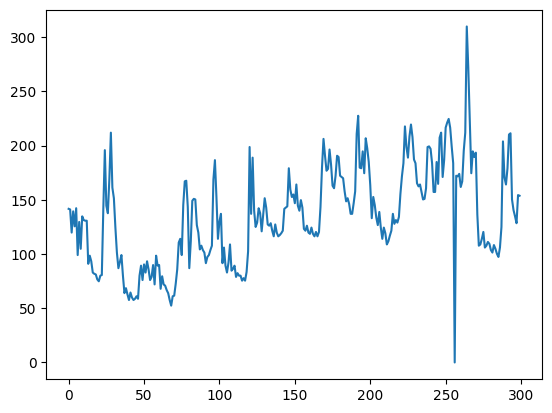

In [22]:
import matplotlib.pyplot as plt
plt.plot(tests[0][:300])

## Archive

In [25]:

true_tss = np.concatenate(true_tss, 0)
recons_tss = np.concatenate(recons_tss, 0)
true_segs = np.concatenate(true_segs, 0)
pred_segs = np.concatenate(pred_segs, 0)
seg_metrics = evaluation.evaluate_segmentation(
    true_segs, pred_segs, K=config["num_categories"]
)
#print(config["dataset"], seg_metrics)


In [26]:
seg_metrics

{'nmi_score': 0.765731146550337,
 'ari_score': 0.8514450465440498,
 'accuracy': 0.961375,
 'f1_score': 0.9614082389518032}

In [30]:
evaluation.evaluate_segmentation(
    true_segs[0], pred_segs[0], K=config["num_categories"]
)

{'nmi_score': 1.0, 'ari_score': 1.0, 'accuracy': 1.0, 'f1_score': 1.0}

In [ ]:

pred_segs = []
true_segs = []
for test_batch, test_label in tqdm(test_loader):
    test_batch = test_batch.to(device)
    pred = model.predict(test_batch, num_samples=100)
    true = test_batch[:, config['context_length']:]
    pred_segs.append(torch2numpy(torch.argmax(pred['z_emp_probs'], dim=-1)))
    true_segs.append(torch2numpy(test_label[:, config['context_length']:]))


In [106]:
seg_error = evaluation.evaluate_segmentation(np.concatenate(true_segs, 0), np.concatenate(pred_segs, 0), K=config["num_categories"])

seg_error

{'nmi_score': 0.10380844559277072,
 'ari_score': 0.140397887557092,
 'accuracy': 0.68736,
 'f1_score': 0.6873676161666078}

In [84]:
np.mean(mses)

0.08520873

In [97]:
pred_segs

tensor([[0, 0, 0,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1]])